In [1]:
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Observations
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import QTable

import re

%matplotlib inline

----

In [2]:
def get_tic_info(ticid, radius_deg=.10, maglimit = 14.5, cols=['ID', 'Tmag', 'Jmag', 'Teff','logg','ra', 'dec','TWOMASS','dstArcSec']):

    starName = "TIC " + str(ticid)
    catalogData = Catalogs.query_object(starName, radius = radius_deg, catalog = "TIC")
    want = catalogData['Tmag'] <= maglimit
    #I always want the first two regardless of magnitude, it returns sorted by angular distance
    want[0:2] = [True, True]
    
    return(catalogData[want][cols])
    


In [3]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')



def overplot_ticffi(targetlist, cutout_deg = .1,nearest=10):
    """
    Plot tic positions on top of an ffi
    sector =0 means use the first available, otherwise use the specified sector.
    targetlist is a astropy table containing ID, ra, dec, Tmag
    The cutout will be performed around the first ra/dec
    """
    
    ra = targetlist[0]['ra']
    dec = targetlist[0]['dec']

    coord = SkyCoord(ra, dec, unit = "deg")
    
    npixels = 2*np.ceil(cutout_deg*3600/21) + 4 #This assumes 21arcsecond pixels)
    
    if npixels > 60:
        npixels = 60
        print("Warning: cutout size set to 80 pixels.")
    if npixels < 10:
        npixels = 10
    
    try:
        hdulist = Tesscut.get_cutouts(coord, size = npixels)
    except:
        print["Cutout not available"]
        return
    
    hdu = hdulist[0]
    firstImage = hdu[1].data['FLUX'][0]

    wcs = WCS(hdu[2].header)

    fig = plt.figure(figsize = (6, 6))
    fig.add_subplot(111, projection = wcs)
    plot_cutout(firstImage)

    plt.xlabel('RA', fontsize = 12)
    plt.ylabel('Dec', fontsize = 12)


    starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
    plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

    # Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
    nearby_stars = list( map( lambda x,y:[x,y], targetlist['ra'], targetlist['dec'] ) )
    
    # Plot nearby stars as well, which we created using our Catalog call above.
    nearby_loc = wcs.all_world2pix(nearby_stars[1:nearest],0)
    plt.scatter(nearby_loc[1:nearest, 0], nearby_loc[1:nearest, 1], 
                s = 25, color = 'orange')
    
    for i,v in enumerate(nearby_loc[:nearest]):
        plt.annotate(str(i), (nearby_loc[i][0], nearby_loc[i][1]),
                     textcoords="offset points", xytext=(2,2), ha='left',
                    color = 'red', fontsize=15)
    plt.title("TIC "+ str(targetlist[0]['ID']))
    
    return firstImage, wcs

In [4]:
def get_twomin_obs(ticlist):
    """
    Given a list of ticids, return a table of all the data that is available on that target.
    The table will be well formated to just be one one describing 
    the available sectors per target.
    
    Input: list of ticids, int
    Return: full table (astropy table of tic, obsid, filenames, camera, ccd)
            for all relevant two minute data files.
            summary table (one line per ticid), list of sectors, list of camera and ccd
    """
    
    sectors=[]
    gis=[]
    obsid=[]
    tmin=[]
    tmax=[]
    exptime=[]
    target=[]
    
    dv_sectors=[]
    dv_obsid=[]
    dv_tmin=[]
    dv_tmax=[]
    dv_target=[]
    dv_exptime=[]
    
    for tic in ticlist:
        observations = Observations.query_criteria(obs_collection = "TESS",
                                             dataproduct_type = ["timeseries"],
                                             target_name = tic)
        if len(observations) > 0:
            observations.sort(keys=['sequence_number', 'target_name'])
            
            for obs in observations:
                #Match for multi-sector observations
                match = re.search("s\d\d\d\d-s\d\d\d\d",obs['obs_id'])
                
                if match == None:
                
                    if int(obs['target_name']) == int(tic):
                        obsid.append(obs['obs_id'])
                        gis.append(obs['proposal_id'])
                        sectors.append(obs['sequence_number'])
                        tmin.append(obs['t_min'])
                        tmax.append(obs['t_max'])
                        exptime.append(int(obs['t_exptime']/60.0))
                        target.append(obs['target_name'])
                    
                else:
                    dv_sectors.append(match.group(0))
                    dv_obsid.append(obs['obs_id'])
                    dv_tmin.append(obs['t_min'])
                    dv_tmax.append(obs['t_max'])
                    dv_target.append(obs['target_name'])
                    dv_exptime.append(int(obs['t_exptime']/60.0))
    
    ts_table = QTable([target, sectors, gis, obsid, exptime, tmin,tmax],
                 names=('target_tic', 'sectors', 'GI_nums', 'obs_id', 'Exp_time_min','t_min','t_max'),
                 meta={'name':'observation table'})
    dv_table = QTable([dv_target, dv_sectors, dv_obsid, dv_exptime, dv_tmin, dv_tmax],
                 names=('target_tic', 'sector_range','obs_id', 'Exp_time_min','t_min','t_max'),
                 meta={'name':'Multi-Sector Planet Search'})
    
    return ts_table, dv_table
    

In [5]:
ticlist = [261105201]

obs_table, dv_table = get_twomin_obs(ticlist)
obs_table.show_in_notebook()

idx,target_tic,sectors,GI_nums,obs_id,Exp_time_min,t_min,t_max
0,261105201,1,G011154_G011048_G011250,tess2018206045859-s0001-0000000261105201-0120-s,2,58324.79285543,58352.6761776
1,261105201,2,G011154_G011048_G011250,tess2018234235059-s0002-0000000261105201-0121-s,2,58353.60117736,58381.01367064
2,261105201,4,G011154_G011048_G011250,tess2018292075959-s0004-0000000261105201-0124-s,2,58410.39977455,58436.34976819
3,261105201,5,G011154_G011048_G011250,tess2018319095959-s0005-0000000261105201-0125-s,2,58437.47615681,58463.78726148
4,261105201,7,G011154_G011048_G011250,tess2019006130736-s0007-0000000261105201-0131-s,2,58491.12473295,58515.58583387
5,261105201,8,G011154_G011048_G011250,tess2019032160000-s0008-0000000261105201-0136-s,2,58516.83999998,58541.49971185
6,261105201,11,G011154_G011048_G011250,tess2019112060037-s0011-0000000261105201-0143-s,2,58596.27052234,58623.39134414
7,261105201,12,G011154_G011048_G011250,tess2019140104343-s0012-0000000261105201-0144-s,2,58624.44828816,58652.39133183
8,261105201,13,G011154_G011048_G011250,tess2019169103026-s0013-0000000261105201-0146-s,2,58653.41355347,58681.85659691


In [6]:
dv_table.show_in_notebook()

idx,target_tic,sector_range,obs_id,Exp_time_min,t_min,t_max
0,261105201,s0001-s0002,tess2018206190142-s0001-s0002-0000000261105201-00111,2,58324.79400419,58381.01388402
1,261105201,s0001-s0006,tess2018206190142-s0001-s0006-0000000261105201-00196,2,58324.79400419,58463.78607698
2,261105201,s0001-s0009,tess2018206190142-s0001-s0009-0000000261105201-00205,2,58324.79400419,58541.49913238
3,261105201,s0001-s0013,tess2018206190142-s0001-s0013-0000000261105201-00226,2,58324.79400419,58681.85780811


In [7]:
obs_table.sort(keys=['sectors'])

In [8]:
import re

match = re.search("s\d\d\d\d-s\d\d\d\d",'tess2018206190142-s0001-s0006-0000000261105201-00196')
print(match)
if match == None:
    print('hi')
#obs_table

<re.Match object; span=(18, 29), match='s0001-s0006'>


## Input Catalog and Scene Information

In [14]:
ticid=272489043
size=.11 #size in degrees
maglimit = 15
nearest=11
cols=['ID', 'Tmag', 'Jmag', 'Teff','logg','ra', 'dec','dstArcSec']

In [15]:
ticinfo = get_tic_info(ticid, radius_deg = size, cols=cols)
ticinfo.show_in_notebook(display_length=nearest)


idx,ID,Tmag,Jmag,Teff,logg,ra,dec,dstArcSec
0,272489043,8.26636,8.033,8400.0,3.74688,296.564714099499,43.9475942241155,0.0
1,1881230276,19.5799,nan,nan,nan,296.569034680852,43.9480903138861,11.340023436841728
2,272489007,14.182,13.501,nan,nan,296.553927,43.933909,56.64904501350514
3,1881230237,14.3339,nan,6280.0,3.71312,296.553991050993,43.9338067750824,56.88808805366614
4,272489081,13.7844,12.599,4669.0,nan,296.578047913126,43.9634053655751,66.58811731959132
5,272489012,13.7921,12.664,4609.0,nan,296.587157745921,43.9348409284229,74.1120460093316
6,272489100,12.0522,11.522,6707.35,4.22404,296.555971341155,43.9677616542631,76.05577119446856
7,272489085,14.0833,12.766,4434.0,nan,296.5432612775,43.9644056982799,82.18110316873836
8,272488984,13.1168,12.575,6598.01,4.25315,296.577293766998,43.9233401497028,93.2061932773044
9,272488975,13.6962,12.959,5949.0,3.67986,296.576294338452,43.9203427539854,102.59608911768139


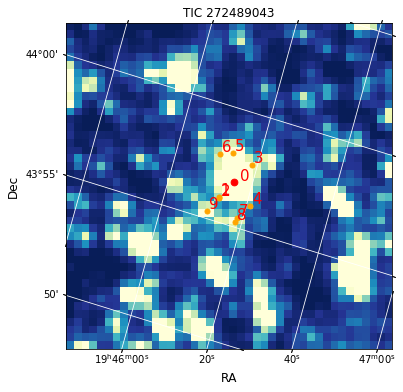

In [16]:
image, wcs = overplot_ticffi(ticinfo, cutout_deg = size, nearest=nearest)

In [17]:
ticlist = ticinfo['ID']
obs_table, dv_table = get_twomin_obs(ticlist[0:3])
obs_table.show_in_notebook()

idx,target_tic,sectors,GI_nums,obs_id,Exp_time_min,t_min,t_max
0,272489043,14,G022062,tess2019198215352-s0014-0000000272489043-0150-s,2,58682.84687433,58709.70380731
1,272489043,15,G022062,tess2019226182529-s0015-0000000272489043-0151-s,2,58710.85797325,58736.9093508


In [18]:
dv_table.show_in_notebook()

idx,target_tic,sector_range,obs_id,Exp_time_min,t_min,t_max
